In [1]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn import model_selection
from sklearn.svm import SVR
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


# Settando configurações padrão para todos os modelos

In [2]:
df = pd.read_csv(os.getcwd() + '/DATABASE/base-reduzida-v5.csv', sep = ',')
df = df.drop(df.columns[0], axis=1)
df.head()

,Estado de saúde,Pouco Interesse em atividades,Frequência de consumo de bebida,Qtde dias na semana que bebe,Qtde doses quando bebe,Aviso bebida últimos 12M,Falta de memória após beber nos últimos 12M,Mais de 5 doses em uma ocasião nos últimos 30D,Problemas com cansaço,Problemas para dormir,Sentimento depressivo,Sentimento de fracasso,Ideação suicida,Diagnóstico de depressão,Diagnóstico de alcoolismo,Alcoolismo e Depressão
0,1.0,1.0,2.0,0.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [3]:
seed = 101 # Para que a separação dos dados ocorra sempre a partir da mesma semente (seed), e seja reproduzível em qualquer execução

In [4]:
#Randomizando os dados do Dataframe
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [5]:
X = df.drop(columns=["Alcoolismo e Depressão", "Diagnóstico de depressão", "Diagnóstico de alcoolismo"], axis=1)
Y = df["Diagnóstico de depressão"]


print("X:", len(X), "Y:", len(Y))

X: 16779 Y: 16779


In [6]:
test_size = 0.4 # Tamanho do conjunto de teste

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = test_size, random_state=seed, stratify=Y)

In [7]:
# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, Y_train)

In [8]:
y_train_smote

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10131    1.0
10132    1.0
10133    1.0
10134    1.0
10135    1.0
Name: Diagnóstico de depressão, Length: 10136, dtype: float64

In [9]:
# Ajustar o MinMaxScaler aos dados de treinamento
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

## Modelo de Regressão Logística

In [10]:
# Inicializando o modelo de regressão logística
RegLog = LogisticRegression()

# Treinando o modelo com o conjunto de dados de treinamento
RegLog.fit(X_train_scaled, y_train_smote)

# Realizando previsões com o conjunto de dados de teste
Y_predRegLog = RegLog.predict(X_test_scaled)

# Avaliando o modelo
accuracy_rl = accuracy_score(Y_test, Y_predRegLog)
conf_matrix = confusion_matrix(Y_test, Y_predRegLog)
class_report = classification_report(Y_test, Y_predRegLog)

# Exibindo os resultados
print(f"Acurácia geral do modelo: {accuracy_rl:.2%}")
print('Matriz de confusão:\n', conf_matrix)
print('Relatório de classificação:\n', class_report)




Acurácia geral do modelo: 97.68%
Matriz de confusão:
 [[3378    1]
 [ 155 3178]]
Relatório de classificação:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3379
         1.0       1.00      0.95      0.98      3333

    accuracy                           0.98      6712
   macro avg       0.98      0.98      0.98      6712
weighted avg       0.98      0.98      0.98      6712



## SVR com RBF

Métricas de Avaliação: 
 MAE: 0.10838674061880092 
 MSE: 0.026958153848964536 
 RMSE: 0.16418938409338327 
 R2: 0.8921623195708367


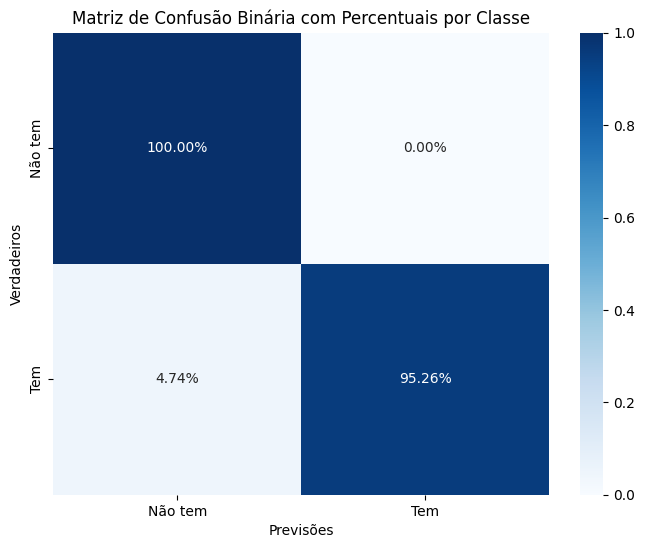

Acurácia da classe 'Não tem': 100.00%
Acurácia da classe 'Tem': 95.26%
Acurácia geral do modelo: 97.65%


In [11]:
# Criar uma instância do modelo SVR com kernel rbf
svr = SVR(kernel='rbf')
# Realizar a validação cruzada (por exemplo, com 5-fold)
cv_scores = cross_val_score(svr, X, Y, cv=10, scoring='neg_mean_absolute_error')
# Calcular a média dos scores e inverter o sinal (porque a função de scoring retorna negativo)
mean_cv_score = -np.mean(cv_scores)
# Treinar o modelo SVR com seus dados de treinamento
svr.fit(X_train_scaled, y_train_smote)
# Fazer previsões com o modelo treinado
y_pred_svr = svr.predict(X_test_scaled)
# Métricas 
mae = mean_absolute_error(Y_test, y_pred_svr)
mse = mean_squared_error(Y_test, y_pred_svr)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred_svr)



# Exibir o MAE nos dados de teste
print("Métricas de Avaliação: \n MAE: %s \n MSE: %s \n RMSE: %s \n R2: %s" %(mae, mse, rmse, r2 ))
# Definindo um limiar para classificar as saídas como 'Tem' ou 'Não tem'
threshold = 0.5
# Discretizando os valores verdadeiros e as previsões
Y_test_discrete = (Y_test >= threshold).astype(int)
y_pred_svr_discrete = (y_pred_svr >= threshold).astype(int)
# Definindo as labels para a matriz de confusão
labels = ['Não tem', 'Tem']
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(Y_test_discrete, y_pred_svr_discrete, labels=[0, 1])
# Calculando a acurácia por classe
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
# Criando uma nova matriz de confusão para exibir as porcentagens
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
# Plotando a matriz de confusão com porcentagens
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, ax=ax, cmap='Blues', fmt='.2%', xticklabels=labels, yticklabels=labels)
# Configurando título e eixos
ax.set_title('Matriz de Confusão Binária com Percentuais por Classe')
ax.set_xlabel('Previsões')
ax.set_ylabel('Verdadeiros')
plt.show()

# Exibindo a acurácia por classe
for i, label in enumerate(labels):
    print(f"Acurácia da classe '{label}': {accuracy_per_class[i]:.2%}")
# Exibindo a acurácia geral
accuracy_svr = accuracy_score(Y_test_discrete, y_pred_svr_discrete)
print(f"Acurácia geral do modelo: {accuracy_svr:.2%}")

## Classificador Random Florest 

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Inicializando o modelo Random Forest com o número desejado de árvores
# n_estimators é o número de árvores na floresta
rf = RandomForestClassifier(n_estimators=1000, random_state=seed)

# Treinando o modelo com os dados de treinamento
rf.fit(X_train_scaled, y_train_smote)

# Fazendo previsões no conjunto de teste
Y_pred_rf = rf.predict(X_test_scaled)

# Calculando a acurácia
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)

# Obtendo a matriz de confusão
confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)

# Obtendo o relatório de classificação
classification_report_rf = classification_report(Y_test, Y_pred_rf)

# Imprimindo os resultados
print(f"Acurácia geral do modelo: {accuracy_rf:.2%}")
print(f'Matriz de confusão (Random Forest):\n {confusion_matrix_rf}')
print(f'Relatório de classificação (Random Forest):\n {classification_report_rf}')


Acurácia geral do modelo: 97.63%
Matriz de confusão (Random Forest):
 [[3368   11]
 [ 148 3185]]
Relatório de classificação (Random Forest):
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3379
         1.0       1.00      0.96      0.98      3333

    accuracy                           0.98      6712
   macro avg       0.98      0.98      0.98      6712
weighted avg       0.98      0.98      0.98      6712



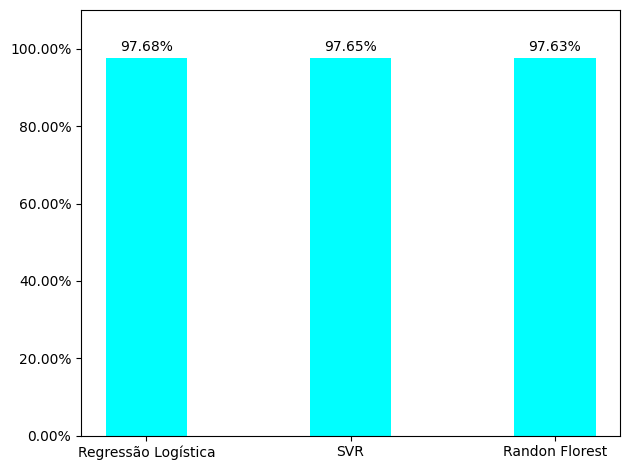

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Nomes dos modelos
models = ['Regressão Logística', 'SVR', 'Randon Florest']

# Acurácias dos modelos
accuracies = [accuracy_rl * 100, accuracy_svr * 100, accuracy_rf * 100] # Substitua com as acurácias reais dos seus modelos

# Configurações do gráfico
index = np.arange(len(models))  # Localização dos modelos
bar_width = 0.4  # Largura das barras

# Criando barras para os modelos
fig, ax = plt.subplots()
bars = ax.bar(index, accuracies, bar_width, color='cyan')

# Adicionando os rótulos de porcentagem nas barras com duas casas decimais
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Configurações finais do gráfico

ax.set_xticks(index)
ax.set_xticklabels(models)
ax.set_ylim(0, 110)  # Ajuste para 110 para dar espaço para o rótulo de 100%

# Configurar o formato do eixo Y para porcentagem com duas casas decimais
ax.yaxis.set_major_formatter(PercentFormatter(decimals=2))

# Use tight_layout para ajustar o layout do subplot
plt.tight_layout()

# Exibir o gráfico
plt.show()

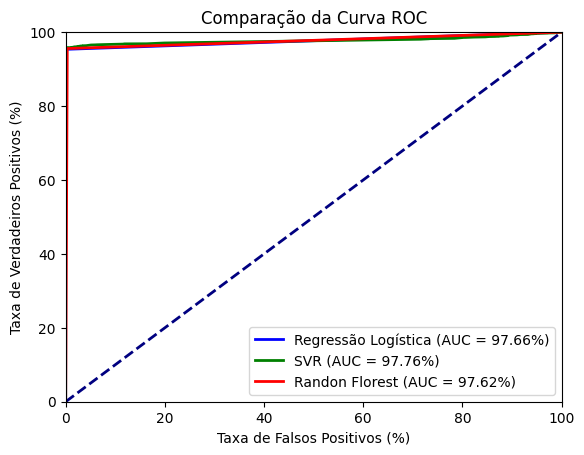

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Suponha que você tenha os valores verdadeiros e os scores previstos para cada modelo
y_true = Y_test  # rótulos verdadeiros
y_score_model1 = Y_predRegLog  # scores do modelo 1
y_score_model2 = y_pred_svr  # scores do modelo 2
y_score_model3 = Y_pred_rf  # scores do modelo 3

# Calcular FPR, TPR e AUC para cada modelo
fpr1, tpr1, _ = roc_curve(y_true, y_score_model1)
fpr2, tpr2, _ = roc_curve(y_true, y_score_model2)
fpr3, tpr3, _ = roc_curve(y_true, y_score_model3)
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)

# Converter as taxas para porcentagem
fpr1, tpr1 = fpr1 * 100, tpr1 * 100
fpr2, tpr2 = fpr2 * 100, tpr2 * 100
fpr3, tpr3 = fpr3 * 100, tpr3 * 100

# Criar a figura
plt.figure()

# Plotar a curva ROC para cada modelo em porcentagem
plt.plot(fpr1, tpr1, color='blue', lw=2, label='Regressão Logística (AUC = %0.2f%%)' % (auc1 * 100))
plt.plot(fpr2, tpr2, color='green', lw=2, label='SVR (AUC = %0.2f%%)' % (auc2 * 100))
plt.plot(fpr3, tpr3, color='red', lw=2, label='Randon Florest (AUC = %0.2f%%)' % (auc3 * 100))

# Plotar a linha de não-discriminação
plt.plot([0, 100], [0, 100], color='navy', lw=2, linestyle='--')

# Adicionar rótulos e título
plt.xlim([0.0, 100.0])
plt.ylim([0.0, 100.0])
plt.xlabel('Taxa de Falsos Positivos (%)')
plt.ylabel('Taxa de Verdadeiros Positivos (%)')
plt.title('Comparação da Curva ROC')
plt.legend(loc="lower right")

# Mostrar o gráfico
plt.show()





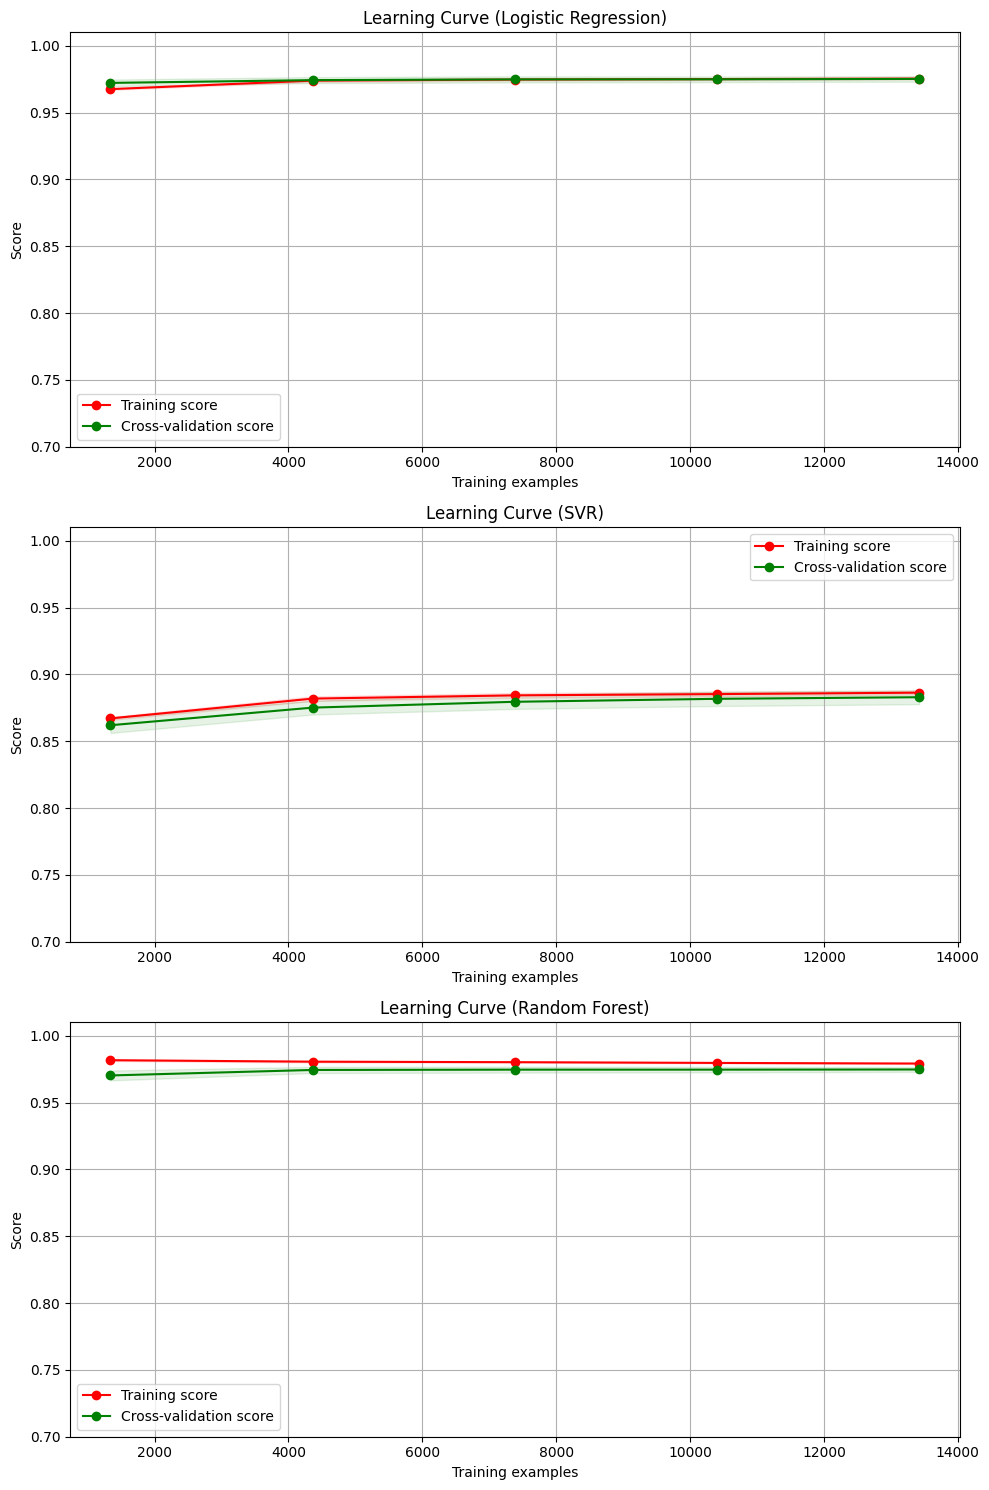

In [15]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")

    axes.legend(loc="best")

    return plt

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot learning curve for Logistic Regression
plot_learning_curve(RegLog, "Learning Curve (Logistic Regression)", X, Y, axes=axes[0], ylim=(0.7, 1.01), cv=5, n_jobs=4)

# Plot learning curve for SVR
# Note: You might need to adjust the SVR model parameters or the scale of your data for this to work properly
plot_learning_curve(svr, "Learning Curve (SVR)", X, Y, axes=axes[1], ylim=(0.7, 1.01), cv=5, n_jobs=4)

# Plot learning curve for Random Forest
plot_learning_curve(rf, "Learning Curve (Random Forest)", X, Y, axes=axes[2], ylim=(0.7, 1.01), cv=5, n_jobs=4)

plt.tight_layout()
plt.show()


# Realizando novas Previsões

In [16]:
# Criando um dicionário com as colunas e preenchendo com 'X'
sem_depressao = {
    'Estado de saúde': [1.0],
    'Pouco Interesse em atividades': [1.0],
    'Frequência de consumo de bebida': [1.0],
    'Qtde dias na semana que bebe': [0.0],
    'Qtde doses quando bebe': [0.0],
    'Aviso bebida últimos 12M': [0.0],
    'Falta de memória após beber nos últimos 12M': [0.0],
    'Mais de 5 doses em uma ocasião nos últimos 30D': [0.0],
    'Problemas com cansaço': [2.0],
    'Problemas para dormir': [0.0],
    'Sentimento depressivo': [0.0],
    'Sentimento de fracasso': [0.0],
    'Ideação suicida': [0.0],
    # As colunas 'Diagnóstico de depressão' e 'Diagnóstico de alcoolismo' são alvos e não devem ser incluídas nos dados de entrada para previsão
}
com_depressao = {
    'Estado de saúde': [1.0],
    'Pouco Interesse em atividades': [4.0],
    'Frequência de consumo de bebida': [3.0],
    'Qtde dias na semana que bebe': [5.0],
    'Qtde doses quando bebe': [32.0],
    'Aviso bebida últimos 12M': [3.0],
    'Falta de memória após beber nos últimos 12M': [4.0],
    'Mais de 5 doses em uma ocasião nos últimos 30D': [1.0],
    'Problemas com cansaço': [4.0],
    'Problemas para dormir': [4.0],
    'Sentimento depressivo': [4.0],
    'Sentimento de fracasso': [4.0],
    'Ideação suicida': [1.0]
}

# Convertendo o dicionário para um DataFrame
df_previsao = pd.DataFrame(com_depressao)

# Exibindo o DataFrame
df_previsao

,Estado de saúde,Pouco Interesse em atividades,Frequência de consumo de bebida,Qtde dias na semana que bebe,Qtde doses quando bebe,Aviso bebida últimos 12M,Falta de memória após beber nos últimos 12M,Mais de 5 doses em uma ocasião nos últimos 30D,Problemas com cansaço,Problemas para dormir,Sentimento depressivo,Sentimento de fracasso,Ideação suicida
0,1.0,4.0,3.0,5.0,32.0,3.0,4.0,1.0,4.0,4.0,4.0,4.0,1.0


In [17]:
# Ajustar o MinMaxScaler aos dados de treinamento
df_scaled = scaler.transform(df_previsao)
df_scaled

array([[0.        , 1.        , 1.        , 0.71428571, 0.76190476,
        1.        , 0.8       , 0.5       , 1.        , 1.        ,
        1.        , 1.        , 0.        ]])

## Regressão Logística:

In [18]:
# Assumindo que `modelo1` é o seu modelo treinado
y_pred_novo = RegLog.predict(df_scaled)

# Se você estiver interessado nas probabilidades
y_pred_proba_novo = RegLog.predict_proba(df_scaled)

# Saída da predição
print("Predição para os novos dados:", y_pred_novo)

# Saída da probabilidade de pertencer à classe positiva
print("Probabilidade de pertencer à classe positiva:", y_pred_proba_novo[:, 1])

Predição para os novos dados: [1.]
Probabilidade de pertencer à classe positiva: [0.99547764]


## Máquina de Vetores de Suporte (SVR):

## Random Forest:

In [19]:
# Assumindo que `modelo1` é o seu modelo treinado
y_pred_novo = rf.predict(df_scaled)

# Se você estiver interessado nas probabilidades
y_pred_proba_novo = rf.predict_proba(df_scaled)

# Saída da predição
print("Predição para os novos dados:", y_pred_novo)

# Saída da probabilidade de pertencer à classe positiva
print("Probabilidade de pertencer à classe positiva:", y_pred_proba_novo[:, 1])

Predição para os novos dados: [1.]
Probabilidade de pertencer à classe positiva: [0.973]
